# 訓練データの対称性関数の値とスパッタリングシミュレーション中の対称性関数の値を比較する
1. 訓練データの対称性関数の値をSymmetryFunctionValueReaderで取得する
2. 取得した値で次元圧縮器の訓練を行う
3. スパッタリングシミュレーションの軌跡に対して同様に対称性関数を計算する
4. 得られた対称性関数の値を２で訓練された次元圧縮器に入力し、次元圧縮を行う
5. 2と4で得られた次元圧縮後の値を比較し、4で外れている原子がある場合はその周りの構造を取得する
6. 5で得られた構造を訓練データに入れてスパッタリングシミュレーションを行う
7. 実験値に近づいていくかどうか確認する
8. 1~7を繰り返す

In [1]:
from mlptools.analyzer.symmetry_function import SymmetryFunctionValueReader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from glob import glob

import umap

1. 訓練データの対称性関数の値をSymmetryFunctionValueReaderで取得する

In [2]:
# path2target = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/n2p2/Si/100/06"
path2target = "/Users/y1u0d2/desktop/Lab/result/n2p2/Si/100/06"
if os.path.exists(os.path.join(path2target, "sf_df_train.csv")):
    sf_df_train = pd.read_csv(os.path.join(path2target, "sf_df_train.csv"))
else:
    atom_num_symbol_map = {
        14: "Si",
        # 8: "O"
    }
    sf_reader = SymmetryFunctionValueReader(path2target)
    sf_df_dict = sf_reader.read(
        atom_num_symbol_map=atom_num_symbol_map,
        number_of_sf_per_atom=30
    )
    sf_df_train = sf_df_dict["Si"]
    sf_df_train.to_csv(os.path.join(path2target, "sf_df_train.csv"), index=False)

In [3]:
sf_df_train.shape

(1827288, 30)

2. 取得した値で次元圧縮器の訓練を行う<br>
変数同士の次元は揃っているのでScalingは必要ない気がするが、念の為StandardScalerを用いたscalingを行う

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_33444/1136395939.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


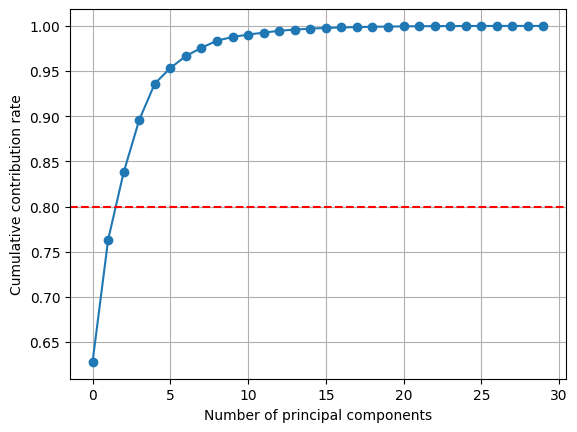

In [4]:
# 次元削減する次元数を確認する(累積寄与率)
# 累積寄与率が80%超えてたらOK
pca = PCA(n_components=sf_df_train.shape[1])
pca.fit(sf_df_train)

ev_ratio = pca.explained_variance_ratio_
cum_ev_ratio = np.cumsum(ev_ratio)

fig, ax = plt.subplots()
ax.plot(cum_ev_ratio, marker="o")
# plot horizontal line at 0.8
ax.axhline(y=0.8, color="red", linestyle="--")
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative contribution rate")
ax.grid()
fig.show()

In [5]:
reducer = PCA(n_components=3)
reducer.fit(sf_df_train)
# reducer = umap.UMAP(n_components=3)
# reducer.fit(sf_df_train.sample(frac=0.2, random_state=42))

PCA(n_components=3)

In [6]:
compressed_sf_train = reducer.transform(sf_df_train)

In [7]:
# 可視化ように20%サンプルする
sampled_compressed_sf_train = pd.DataFrame(compressed_sf_train, columns=["PC1", "PC2", "PC3"]).sample(frac=0.1).reset_index(drop=True)

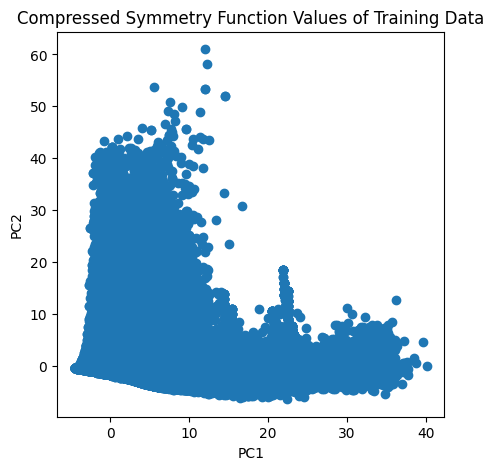

In [8]:
# 2次元で可視化する
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(compressed_sf_train[:, 0], compressed_sf_train[:, 1])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Compressed Symmetry Function Values of Training Data")
plt.show()

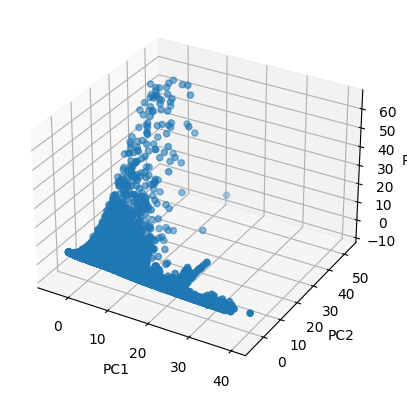

In [9]:
# 3次元で可視化する
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    sampled_compressed_sf_train["PC1"],
    sampled_compressed_sf_train["PC2"],
    sampled_compressed_sf_train["PC3"]
)
# ax.scatter(
#     compressed_sf_train[:, 0],
#     compressed_sf_train[:, 1],
#     compressed_sf_train[:, 2]

# )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

クラスタリングをしてみる

In [37]:
import hdbscan

clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True, min_cluster_size=3)
cluster_labels = clusterer.fit_predict(sampled_compressed_sf_train)

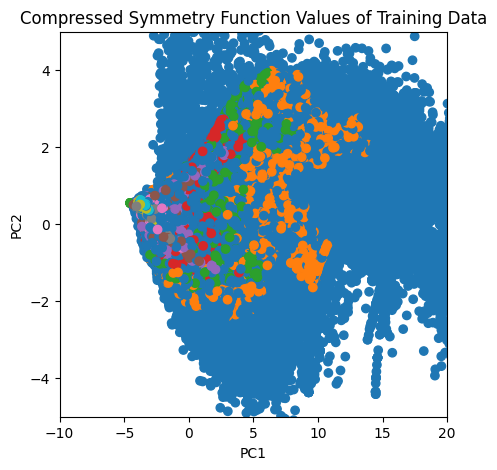

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    sampled_compressed_sf_train["PC1"],
    sampled_compressed_sf_train["PC3"],
    c=cluster_labels,
    cmap="tab10"
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Compressed Symmetry Function Values of Training Data")
ax.set_xlim(-10, 20)
ax.set_ylim(-5, 5)
plt.show()

3. スパッタリングシミュレーションの軌跡に対して同様に対称性関数を計算する

In [10]:
# LAMMPSのデータファイルを読み込む
path2lmp_data = "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_26/0deg_750eV/data_files"
lmp_data_file_list = glob(os.path.join(path2lmp_data, "data.Si.*"))
lmp_data_file_list.sort()
print(f"Number of data files: {len(lmp_data_file_list)}")

Number of data files: 1600


In [42]:
# LAMMPSのdataファイルをASE.Atomsで読み込みn2p2の入力へ変換しinput.dataを作成する
from ase.io import read
from mlptools.io.read import read_from_format
from mlptools.io.write import write_from_atoms

path2n2p2_output = "/Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering"

for target_data in lmp_data_file_list:
    ase_atoms = read(target_data, format="lammps-data")
    mlp_atoms = read_from_format(ase_atoms=ase_atoms, format="ase", has_calculator=False)

    target_dir_name = f"traj_{os.path.basename(target_data)}"
    path2target = os.path.join(path2n2p2_output, target_dir_name)
    os.makedirs(path2target, exist_ok=True)

    with open(os.path.join(path2target, "input.data"), "w") as f:
        lines = write_from_atoms(
            atoms=mlp_atoms,
            format="n2p2",
            structure_id="substrate"
        )
        f.write('\n'.join(lines))
    
    print(f"Finish writing {target_data} to {path2target}")

Finish writing /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_26/0deg_750eV/data_files/data.Si.0 to /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.0
Finish writing /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_26/0deg_750eV/data_files/data.Si.100000 to /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.100000
Finish writing /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_26/0deg_750eV/data_files/data.Si.1000000 to /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.1000000
Finish writing /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_26/0deg_750eV/data_files/data.Si.10000000 to /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.10000000
Finish writing /Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_26/0deg_750eV/data_files/d

対称性関数の計算結果をatomic-env.Gから取り出す

In [11]:
path2n2p2_output = "/Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering"
lmp_traj_sf_dir_list = glob(os.path.join(path2n2p2_output, "traj_*"))
print(f"Number of n2p2 calculated directories: {len(lmp_traj_sf_dir_list)}")

Number of n2p2 calculated directories: 1600


In [12]:
# 訓練データとスパッタリングの軌跡の圧縮SF値を比較する
atom_num_symbol_map = {
    14: "Si",
    # 8: "O"
}
NUMBER_OF_SF_PER_ATOM = 30
PATH2NNPSCALING = "/Users/y1u0d2/desktop/Lab/result/n2p2/Si/100/06/nnp-scaling.log.0000"

for lmp_traj_sf_dir in lmp_traj_sf_dir_list:
    if os.path.exists(os.path.join(lmp_traj_sf_dir, "compressed_sf_value_limit_range.png")):
        print(f"[Already exists] {lmp_traj_sf_dir}")
        continue
    print(f"Reading {lmp_traj_sf_dir} ...")
    sf_reader = SymmetryFunctionValueReader(lmp_traj_sf_dir, path2nnpscaling=PATH2NNPSCALING)
    sf_df_dict = sf_reader.read(
        atom_num_symbol_map=atom_num_symbol_map,
        number_of_sf_per_atom=NUMBER_OF_SF_PER_ATOM,

    )
    sf_df_traj = sf_df_dict["Si"]

    compressed_sf_value_matrix_from_lmp_traj = reducer.transform(sf_df_traj)

    # 2次元で可視化する
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(sampled_compressed_sf_train["PC1"], sampled_compressed_sf_train["PC2"], label="train data", alpha=0.5)
    ax.scatter(compressed_sf_value_matrix_from_lmp_traj[:, 0], compressed_sf_value_matrix_from_lmp_traj[:, 1], label="sputtering simulation trajectory")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_title(f"Compressed Symmetry Function Values: {os.path.basename(lmp_traj_sf_dir).split('_')[-1]}")
    ax.legend()
    fig.savefig(os.path.join(lmp_traj_sf_dir, "compressed_sf_value_limit_range.png"))
    plt.close()

Reading /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.30120000 ...
All files exist
[PROGRESS] 0/4812


Si symmetry function columns are created
Symmetry function dataframe of Si is created
Reading /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.30060000 ...
All files exist
[PROGRESS] 0/4816
Si symmetry function columns are created
Symmetry function dataframe of Si is created
[Already exists] /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.23180000
[Already exists] /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.24560000
[Already exists] /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.23300000
[Already exists] /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.23240000
[Already exists] /Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering/traj_data.Si.24420000
[Already exists] /Users/y1u0d2/desktop/Lab/result/n2p2/Si/ext

4. 得られた対称性関数の値を２で訓練された次元圧縮器に入力し、次元圧縮を行う

In [14]:
# scaling
# sf_value_matrix_from_lmp_traj_scaled = scaler.transform(sf_value_matrix_from_lmp_traj)
# compress
compressed_sf_value_matrix_from_lmp_traj = reducer.transform(sf_df_traj)

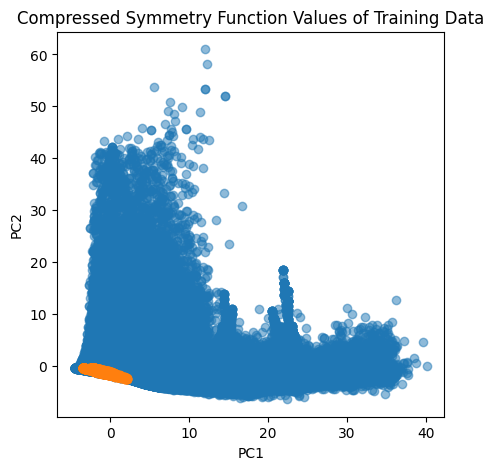

In [15]:
# 2次元で可視化する
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(compressed_sf_train[:, 0], compressed_sf_train[:, 1], label="train data", alpha=0.5)
ax.scatter(compressed_sf_value_matrix_from_lmp_traj[:, 0], compressed_sf_value_matrix_from_lmp_traj[:, 1], label="sputtering trajectory")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
# ax.set_xlim(-5, 1)
# ax.set_ylim(-2, 1)
ax.set_title("Compressed Symmetry Function Values of Training Data")
plt.show()

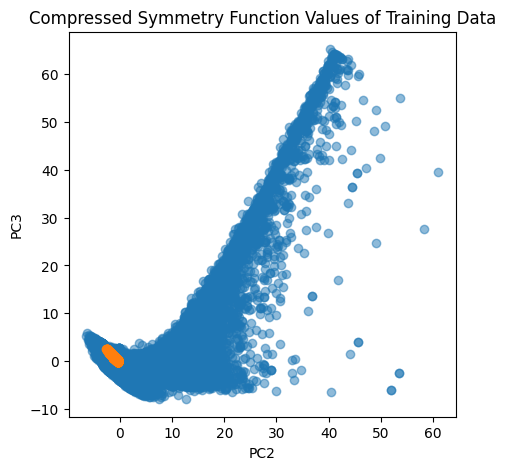

In [16]:
# 2次元で可視化する
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(compressed_sf_train[:, 1], compressed_sf_train[:, 2], label="train data", alpha=0.5)
ax.scatter(compressed_sf_value_matrix_from_lmp_traj[:, 1], compressed_sf_value_matrix_from_lmp_traj[:, 2], label="sputtering trajectory")
ax.set_xlabel("PC2")
ax.set_ylabel("PC3")
# ax.set_xlim(-5, 1)
# ax.set_ylim(-2, 1)
ax.set_title("Compressed Symmetry Function Values of Training Data")
plt.show()

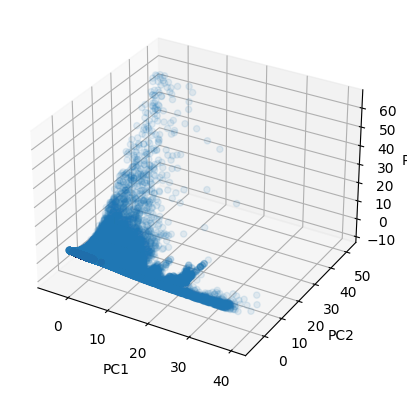

In [28]:
# 3次元で可視化する
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    sampled_compressed_sf_train["PC1"],
    sampled_compressed_sf_train["PC2"],
    sampled_compressed_sf_train["PC3"],
    label="train data",
    alpha=0.1
)
ax.scatter(
    compressed_sf_value_matrix_from_lmp_traj[:, 0],
    compressed_sf_value_matrix_from_lmp_traj[:, 1],
    compressed_sf_value_matrix_from_lmp_traj[:, 2],
    label="sputtering trajectory",
    c="red"
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [14]:
# compressed_sf_value.pngをまとめてgifにする
from PIL import Image

img_list = []
lmp_traj_sf_dir_list = sorted(lmp_traj_sf_dir_list, key=lambda x: int(x.split("_")[-1].split(".")[-1]))

for lmp_traj_sf_dir in lmp_traj_sf_dir_list:
    if not os.path.exists(os.path.join(lmp_traj_sf_dir, "compressed_sf_value_limit_range.png")):
        continue

    img = Image.open(os.path.join(lmp_traj_sf_dir, "compressed_sf_value_limit_range.png"))
    img_list.append(img)

img_list[0].save(
    os.path.join("/Users/y1u0d2/desktop/Lab/result/n2p2/Si/extrapolation_analysis/20231111_sputtering", "compressed_sf_value_limit_range.gif"),
    save_all=True,
    append_images=img_list[1:],
    duration=10,
    loop=0
)